
# Case Analytics de **Churn** – Dados Fictícios

Este notebook foi desenvolvido como intuito de **prever churn**, incluindo:
- **Tratamento inicial e integração de dados**
- **Análises visuais** para entender drivers de churn
- **Treino e comparação de 3 modelos preditivos** (Logistic Regression, Random Forest, Gradient Boosting)
- **Avaliação visual** (ROC/PR, matriz de confusão) e **escolha do melhor modelo**


In [14]:

#@title Instalando dependências (caso necessário)
!pip -q install pandas numpy scikit-learn matplotlib joblib


In [2]:

# Importsndo as principais bibliotecas para desenvolvimento
import os, io, re, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
import joblib

# Configurando os visuais
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True
RANDOM_STATE = 42



## Carregar dados
Escolha **uma** das opções abaixo:
- **Upload direto** dos arquivos `customer_original.csv` e `customer_social.csv`


- Utilizei a versão de carregar os arquivos diretamente aqui pelo drive devido a problemas entre meu colab e drive

In [3]:

#@title Upload direto dos CSVs
from google.colab import files

try:
    uploaded = files.upload()  # selecione: customer_original.csv e customer_social.csv
    def read_uploaded_csv(name):
        for fname, buf in uploaded.items():
            if fname.endswith(name):
                return pd.read_csv(io.BytesIO(buf))
    orig = read_uploaded_csv("customer_original.csv")
    social = read_uploaded_csv("customer_social.csv")
    print("Arquivos carregados via upload.")
except Exception as e:
    print("Upload não realizado nesta sessão:", e)


Saving customer_nps.csv to customer_nps.csv
Saving customer_original.csv to customer_original.csv
Saving customer_social.csv to customer_social.csv
Arquivos carregados via upload.



## Tratamento inicial e *merge* por CPF das bases
Normalizei o campo de CPF das bases e fiz o join para trazer informações de `customer_original` (informações de serviços/contratos e `Churn`) com `customer_social` (demografia).


In [4]:

def normalize_cpf_series(s: pd.Series) -> pd.Series:
    """Normaliza CPF mantendo apenas dígitos e preenchendo à esquerda até 11 dígitos."""
    return s.astype(str).str.replace(r"\D", "", regex=True).str.zfill(11)

# Valida presença de cpf e normaliza
assert "cpf" in orig.columns, "Coluna 'cpf' ausente em customer_original.csv"
assert "cpf" in social.columns, "Coluna 'cpf' ausente em customer_social.csv"
orig["cpf"] = normalize_cpf_series(orig["cpf"])
social["cpf"] = normalize_cpf_series(social["cpf"])

# Dedup no social
social = social.drop_duplicates(subset=["cpf"], keep="first")

# Converter colunas numéricas do original (se existirem)
for col in ["TotalCharges", "MonthlyCharges", "tenure"]:
    if col in orig.columns:
        orig[col] = pd.to_numeric(orig[col], errors="coerce")

# Join
df = orig.merge(social, on="cpf", how="left")

# Criar target binário a partir de 'Churn'
df["ChurnFlag"] = (
    orig["Churn"].astype(str).str.strip().str.lower()
        .map({"yes":1,"no":0,"1":1,"0":0})
)

# Fallback simples se algo ficar NaN
if df["ChurnFlag"].isna().any():
    df.loc[df["ChurnFlag"].isna(), "ChurnFlag"] = (
        orig["Churn"].astype(str).str.contains("y|1|sim|true", case=False, regex=True).astype(int)
    )

print("Shape final:", df.shape, "| Taxa de churn:", round(df["ChurnFlag"].mean(), 3))
df.head(3)


Shape final: (7234, 22) | Taxa de churn: 0.264


,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cpf,gender,SeniorCitizen,Partner,Dependents,ChurnFlag
0,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Bank transfer (automatic),118.75,8672.45,No,10433218100,Female,0,Yes,Yes,0
1,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Electronic check,118.65,8477.60,No,96001338914,Female,0,No,No,0
2,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Mailed check,118.60,7990.05,No,08386379499,Female,0,Yes,No,0



## Avaliando as colunas da base, os metadados e se há algum campo vazio


In [5]:

summary = pd.DataFrame({
    "col": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "missing_pct": [df[c].isna().mean() for c in df.columns]
}).sort_values("missing_pct", ascending=False)
summary.head(20)


,col,dtype,missing_pct
0,tenure,int64,0.0
1,PhoneService,object,0.0
2,MultipleLines,object,0.0
3,InternetService,object,0.0
4,OnlineSecurity,object,0.0
5,OnlineBackup,object,0.0
6,DeviceProtection,object,0.0
7,TechSupport,object,0.0
8,StreamingTV,object,0.0
9,StreamingMovies,object,0.0



## Iniciando a análise exploratória dos dados


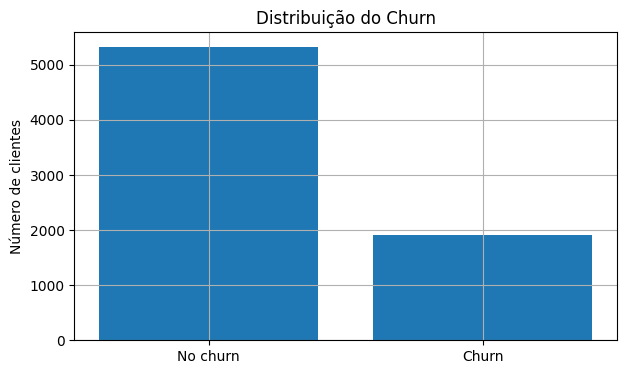

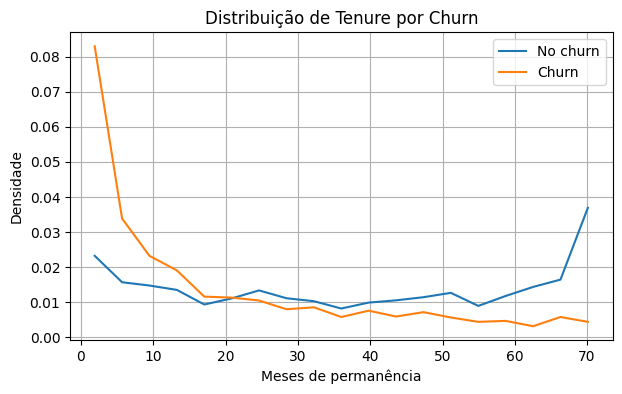

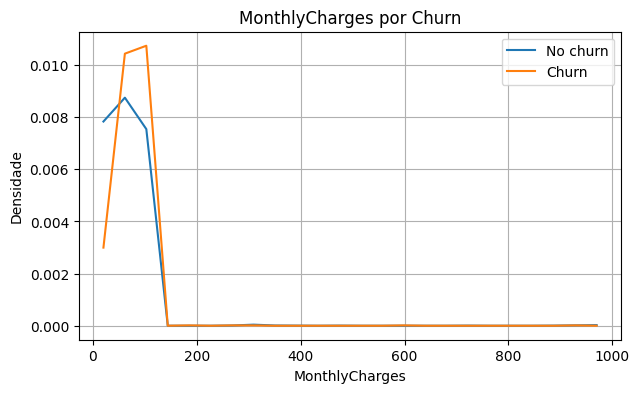

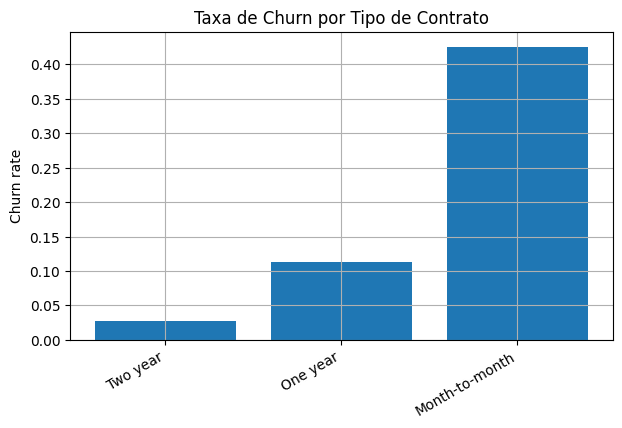

In [6]:

# Distribuição do target
counts = df["ChurnFlag"].value_counts().sort_index()
plt.figure()
plt.bar(["No churn","Churn"], counts.values)
plt.title("Distribuição do Churn")
plt.ylabel("Número de clientes")
plt.show()

# Tenure por churn (densidades simples)
if "tenure" in df.columns and df["tenure"].notna().sum() > 0:
    import numpy as np
    plt.figure()
    bins = np.linspace(0, df["tenure"].dropna().max(), 20)
    for flag, label in [(0, "No churn"), (1, "Churn")]:
        subset = df.loc[df["ChurnFlag"]==flag, "tenure"].dropna()
        if len(subset) > 1:
            hist, bin_edges = np.histogram(subset, bins=bins, density=True)
            centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            plt.plot(centers, hist, label=label)
    plt.title("Distribuição de Tenure por Churn")
    plt.xlabel("Meses de permanência")
    plt.ylabel("Densidade")
    plt.legend()
    plt.show()

# Charges por churn (MonthlyCharges)
if "MonthlyCharges" in df.columns and df["MonthlyCharges"].notna().sum() > 0:
    plt.figure()
    bins = np.linspace(0, df["MonthlyCharges"].dropna().max(), 25)
    for flag, label in [(0, "No churn"), (1, "Churn")]:
        subset = df.loc[df["ChurnFlag"]==flag, "MonthlyCharges"].dropna()
        if len(subset) > 1:
            hist, bin_edges = np.histogram(subset, bins=bins, density=True)
            centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            plt.plot(centers, hist, label=label)
    plt.title("MonthlyCharges por Churn")
    plt.xlabel("MonthlyCharges")
    plt.ylabel("Densidade")
    plt.legend()
    plt.show()

# Churn por categoria de contrato
if "Contract" in df.columns:
    ct = df.groupby("Contract")["ChurnFlag"].mean().sort_values()
    plt.figure()
    plt.bar(ct.index.astype(str), ct.values)
    plt.title("Taxa de Churn por Tipo de Contrato")
    plt.ylabel("Churn rate")
    plt.xticks(rotation=30, ha="right")
    plt.show()


### Avaliação da distribuição do churn
- O objetivo deste gráfico é mostrar o **desbalanceamento** entre clientes que cancelaram e os que permaneceram.
- Se a barra de *No churn* é muito maior, o problema é **desbalanceado**, e métricas como **AP (Average Precision)** e **PR curve** tornam-se mais relevantes que acurácia.


## Construção de features e *preprocessing*
Removi os campos `cpf`, `Churn` e `ChurnFlag` do  dataset. Para features:
- Numéricos → `median` + `StandardScaler`
- Categóricos → `most_frequent` + `OneHotEncoder`


In [7]:

target = "ChurnFlag"
drop_cols = ["cpf","Churn","ChurnFlag"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target].astype(int)

numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_cols),
                  ("cat", categorical_transformer, categorical_cols)]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X.shape, X_train.shape, X_test.shape


((7234, 19), (5787, 19), (1447, 19))


## Comparação de modelos (Cross Validation) – Logistic Regression, Random Forest, Gradient Boosting
Utilizei a validação cruzada (k=5) no conjunto de treino e para realizar a comparação de **ROC AUC** e **Average Precision**.
*Escolhi utilizar o k=5 devido ao processamento e por apresentar boa estabilidade*

In [8]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

candidates = {
    "LogisticRegression": LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

cv_rows = []
for name, model in candidates.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    auc = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    ap = cross_val_score(pipe, X_train, y_train, scoring="average_precision", cv=cv, n_jobs=-1)
    cv_rows.append({"model": name, "roc_auc_mean": auc.mean(), "roc_auc_std": auc.std(),
                    "ap_mean": ap.mean(), "ap_std": ap.std()})

cv_df = pd.DataFrame(cv_rows).sort_values("roc_auc_mean", ascending=False)
cv_df


,model,roc_auc_mean,roc_auc_std,ap_mean,ap_std
2,GradientBoosting,0.846746,0.014058,0.664467,0.022202
0,LogisticRegression,0.842292,0.015272,0.649651,0.034364
1,RandomForest,0.831009,0.012099,0.633186,0.013920


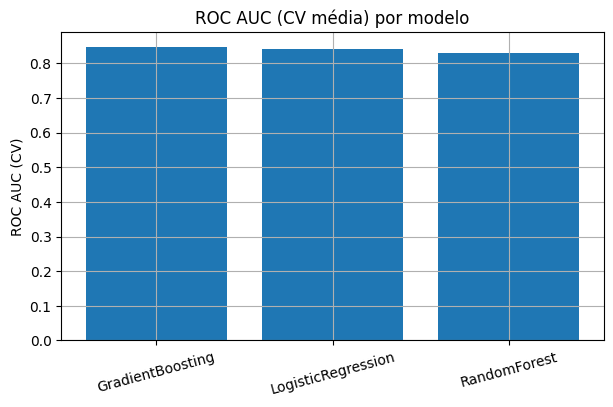

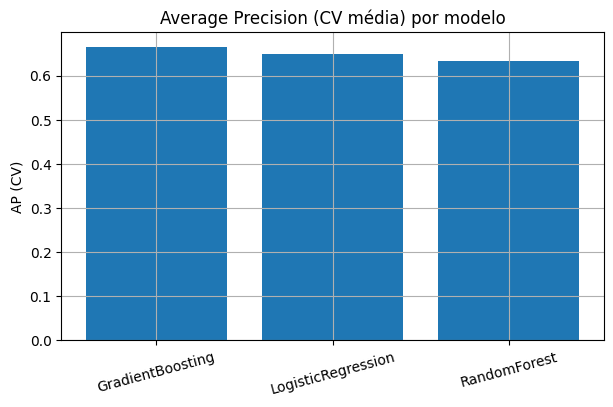

In [9]:

# Visualização da validação cruzada
plt.figure()
plt.bar(cv_df["model"], cv_df["roc_auc_mean"])
plt.title("ROC AUC (CV média) por modelo")
plt.ylabel("ROC AUC (CV)")
plt.xticks(rotation=15)
plt.show()

plt.figure()
plt.bar(cv_df["model"], cv_df["ap_mean"])
plt.title("Average Precision (CV média) por modelo")
plt.ylabel("AP (CV)")
plt.xticks(rotation=15)
plt.show()



## Avaliação no conjunto de teste – Curvas ROC e PR
Treinei cada modelo no treino e fiz a comparação das curvas **ROC** e **Precisão-Revocação** no teste.


In [10]:

fpr_dict, pr_dict, test_rows, fitted = {}, {}, [], {}

for name, model in candidates.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        proba = pipe.predict_proba(X_test)[:,1]
    else:
        proba = pipe.decision_function(X_test)
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    test_rows.append({"model": name, "test_roc_auc": auc, "test_ap": ap})
    fpr, tpr, _ = roc_curve(y_test, proba)
    precision, recall, _ = precision_recall_curve(y_test, proba)
    fpr_dict[name] = (fpr, tpr)
    pr_dict[name] = (recall, precision)
    fitted[name] = (pipe, proba)

test_df = pd.DataFrame(test_rows).sort_values("test_roc_auc", ascending=False)
test_df


,model,test_roc_auc,test_ap
2,GradientBoosting,0.845349,0.650079
0,LogisticRegression,0.844762,0.655140
1,RandomForest,0.830767,0.628470


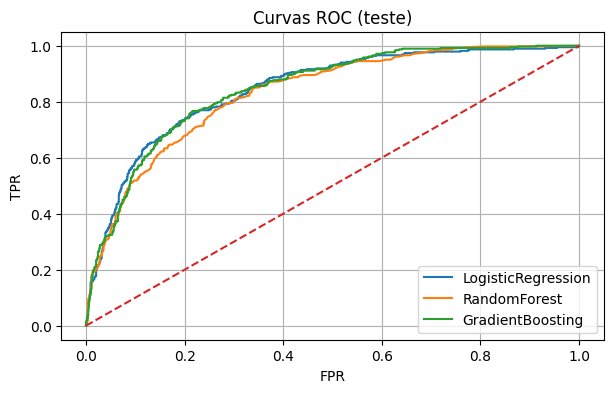

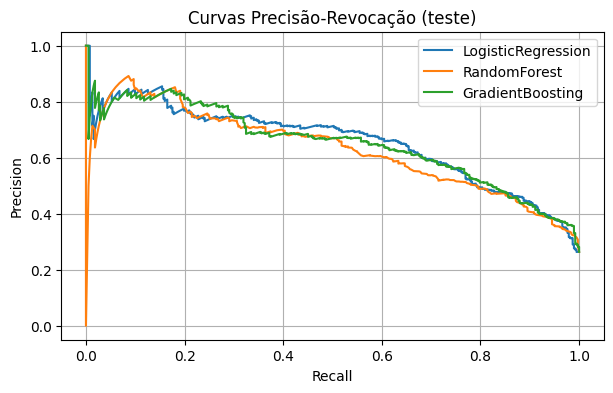

In [11]:

# Curva ROC comparativa
plt.figure()
for name, (fpr, tpr) in fpr_dict.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Curvas ROC (teste)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# Curva Precisão-Revocação comparativa
plt.figure()
for name, (rec, prec) in pr_dict.items():
    plt.plot(rec, prec, label=name)
plt.title("Curvas Precisão-Revocação (teste)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.show()


### Interpretação — Curvas ROC (Teste)
- **ROC** avalia capacidade de **rankear** clientes de risco (Taxa de positivos corretos vs Taxa de falsos positivos).
- Curvas mais próximas do canto superior esquerdo indicam **modelo superior**.
- Fazendo a comparação das linhas por **AUC**: quanto maior, melhor o poder discriminativo.


## Escolhnendo o melhor modelo e ajuste de limiar (threshold)
Fazendo a escolha do melhor modelo com base em **ROC AUC** (e validei com **precisão média (AP)**). Depois, fiz o ajuste do **threshold** para equilibrar *precision* e *recall*.


Melhor por CV: GradientBoosting
ROC AUC (teste): 0.8453494088439888
AP (teste): 0.6500789835696194

Relatório (threshold=0.5)
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1065
           1       0.67      0.51      0.58       382

    accuracy                           0.80      1447
   macro avg       0.75      0.71      0.73      1447
weighted avg       0.79      0.80      0.79      1447



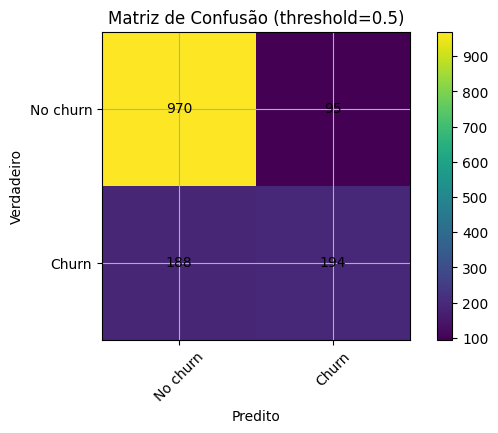

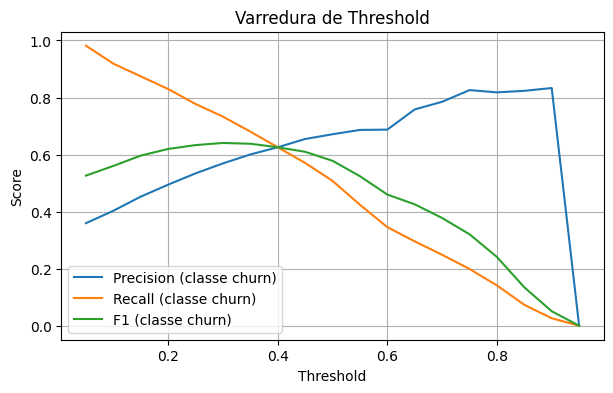

Threshold sugerido (max F1): 0.30


In [12]:

# Escolha preliminar pelo melhor ROC AUC em CV; se empatar, usa teste
best_by_cv = cv_df.iloc[0]["model"]
best_pipe, best_proba = fitted[best_by_cv]

# Relatório em threshold 0.5
y_pred_05 = (best_proba >= 0.5).astype(int)
print(f"Melhor por CV: {best_by_cv}")
print("ROC AUC (teste):", roc_auc_score(y_test, best_proba))
print("AP (teste):", average_precision_score(y_test, best_proba))
print("\nRelatório (threshold=0.5)\n", classification_report(y_test, y_pred_05))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_05)
plt.figure()
im = plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusão (threshold=0.5)")
plt.colorbar(im)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No churn","Churn"], rotation=45)
plt.yticks(tick_marks, ["No churn","Churn"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.ylabel('Verdadeiro'); plt.xlabel('Predito'); plt.show()

# Varredura de thresholds para F1 / Precision / Recall
thresholds = np.linspace(0.05, 0.95, 19)
precisions, recalls, f1s = [], [], []
for th in thresholds:
    yp = (best_proba >= th).astype(int)
    report = classification_report(y_test, yp, output_dict=True, zero_division=0)
    precisions.append(report["1"]["precision"])
    recalls.append(report["1"]["recall"])
    f1s.append(report["1"]["f1-score"])

plt.figure()
plt.plot(thresholds, precisions, label="Precision (classe churn)")
plt.plot(thresholds, recalls, label="Recall (classe churn)")
plt.plot(thresholds, f1s, label="F1 (classe churn)")
plt.title("Varredura de Threshold")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.legend(); plt.show()

best_idx = int(np.argmax(f1s))
best_th = float(thresholds[best_idx])
print(f"Threshold sugerido (max F1): {best_th:.2f}")


### Interpretação — Matriz de Confusão (thr=0.5)
- **FP**: clientes contatados sem necessidade (custo). **FN**: churners não detectados (perda).
- Ajuste o **threshold** para equilibrar **Precision** e **Recall** conforme a estratégia.
- Use esta matriz como *check* operacional antes de implantar.


## Interpretação: importância de variáveis
Mostrando as top features do melhor modelo:
- Se for **árvore** (RandomForest/GradientBoosting): `feature_importances_`
- Se for **LogisticRegression**: coeficientes (após one-hot)


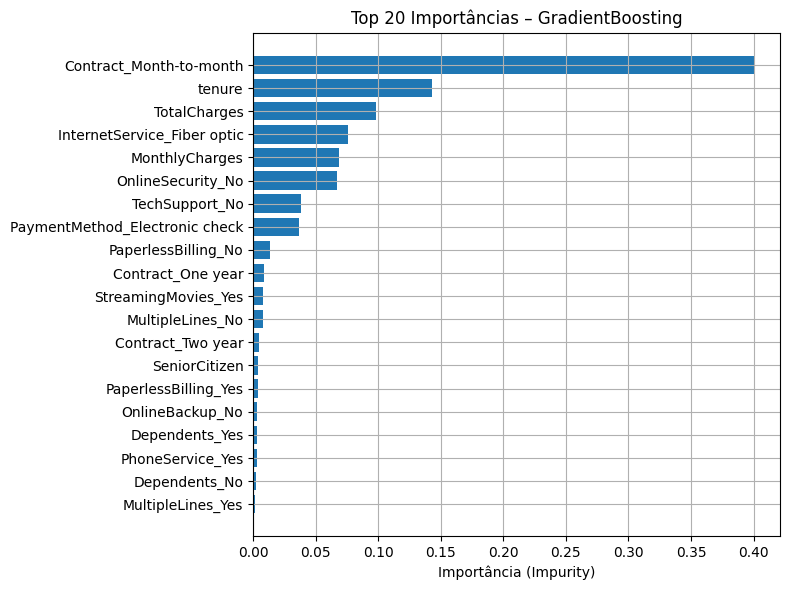

In [13]:

def get_feature_names(preprocess: ColumnTransformer, num_cols, cat_cols):
    ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    return list(num_cols) + cat_feature_names

num_cols = numeric_cols
cat_cols = categorical_cols
feature_names = get_feature_names(best_pipe.named_steps["preprocess"], num_cols, cat_cols)

model = best_pipe.named_steps["model"]
top_k = 20

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    order = np.argsort(importances)[::-1][:top_k]
    plt.figure(figsize=(8, max(4, top_k*0.3)))
    plt.barh([feature_names[i] for i in order][::-1], importances[order][::-1])
    plt.title(f"Top {top_k} Importâncias – {best_by_cv}")
    plt.xlabel("Importância (Impurity)")
    plt.tight_layout()
    plt.show()

elif isinstance(model, LogisticRegression):
    coefs = model.coef_[0]
    order = np.argsort(np.abs(coefs))[::-1][:top_k]
    plt.figure(figsize=(8, max(4, top_k*0.3)))
    plt.barh([feature_names[i] for i in order][::-1], coefs[order][::-1])
    plt.title(f"Top {top_k} Coeficientes – {best_by_cv}")
    plt.xlabel("Peso (coeficiente)")
    plt.tight_layout()
    plt.show()
else:
    print("Modelo não fornece importâncias/coefs nativamente.")


### Interpretação — Importância de Variáveis
- Lista as features que mais **contribuíram** para a separação.
- Use como guia para **ações de negócio** (ex.: contrato, tenure, charges).
- Cuidado: importância não prova causalidade; investigue confounders.


## Conclusão
- **Alvo**: **Churn** (sem NPS como feature).
- **Comparação**: foram avaliados 3 modelos preditivos Logistic Regression, Random Forest e Gradient Boosting.
- **Escolha**: o melhor modelo foi selecionado por **ROC AUC** (avaliado em CV e teste) e validado com **Average Precision**.
- **Interpretação**: fiz a exploração das **importâncias/coefs** e **curvas ROC/PR**; ajustei o **threshold** conforme estratégia.
- **Próximos passos**: calibrar probabilidades, ajustar custo/benefício, adicionar monitoramento (drift, estabilidade de features).
- **Possível nova solução**: utilizar os dados de NPS como feature do modelo e verificar se o mesmo modelo obtém os melhores resultados ou se vale a pena trocar o modelo com base nos testes a serem realizados, pois dessa forma será possível relacionar as duas bases e verificar se há algum plano de ação diferente que consiga atingir tanto o churn quanto a satisfação dos clientes.